# Lightcurve Dataframe Visualization with and without ML

In [1]:
import sys
import os
import re
import time
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import numpy as np
import pandas as pd


sys.path.append('code/')
from data_structures import MultiIndexDFObject
from utils import *

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

try:
    import umap
    import umap.plot
except:
    !pip install umap-learn[plot]

plt.style.use('seaborn-deep')

In [2]:
# load a previously saved file 
parquet_loadname = 'data/df_lc_.parquet.gzip'
parallel_df_lc = MultiIndexDFObject()
parallel_df_lc.data = pd.read_parquet(parquet_loadname)


## What is in this sample?

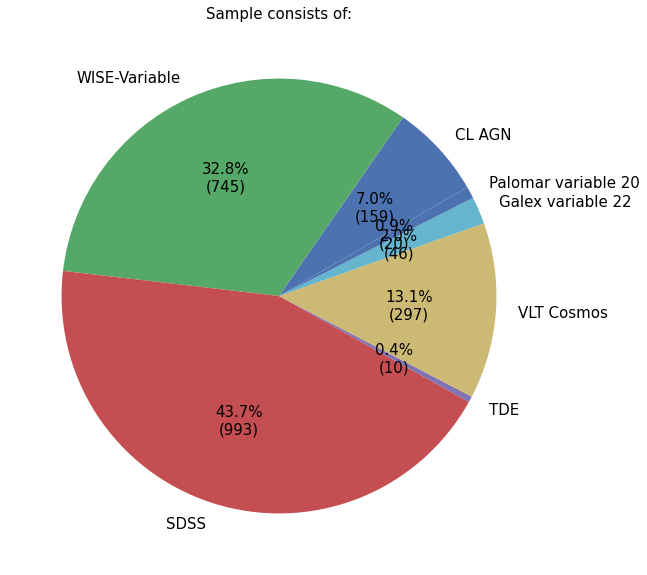

In [3]:
from collections import Counter
numobj = len(parallel_df_lc.data.index.get_level_values('objectid')[:].unique())
seen = Counter()
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']

for b in range(numobj):
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    if label in cl_labels:
        label = ['CL AGN']
    if label=='ZTF-Objname':
        label= ['TDE']
    if label=='Cicco19':
        label= ['VLT Cosmos']
                
    seen.update(label)

plt.figure(figsize=(10,10))
plt.title(r'Sample consists of:',size=15)
h = plt.pie(seen.values(),labels=seen.keys(),autopct=autopct_format(seen.values()), textprops={'fontsize': 15},startangle=30,  labeldistance=1.1)

Text(0, 0.5, '#')

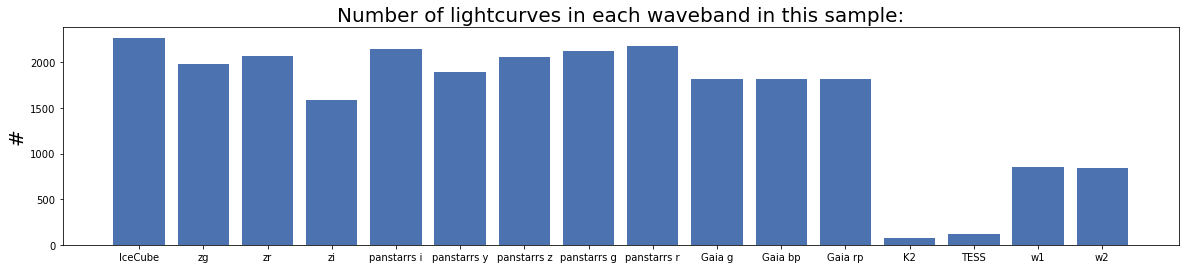

In [4]:
seen = Counter()
for b in range(numobj):
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    bands = singleobj.loc[b,label[0],:,:].index.get_level_values('band')[:].unique()
    seen.update(bands)

plt.figure(figsize=(20,4))
plt.title(r'Number of lightcurves in each waveband in this sample:',size=20)
h = plt.bar(seen.keys(), seen.values())
plt.ylabel(r'#',size=20)

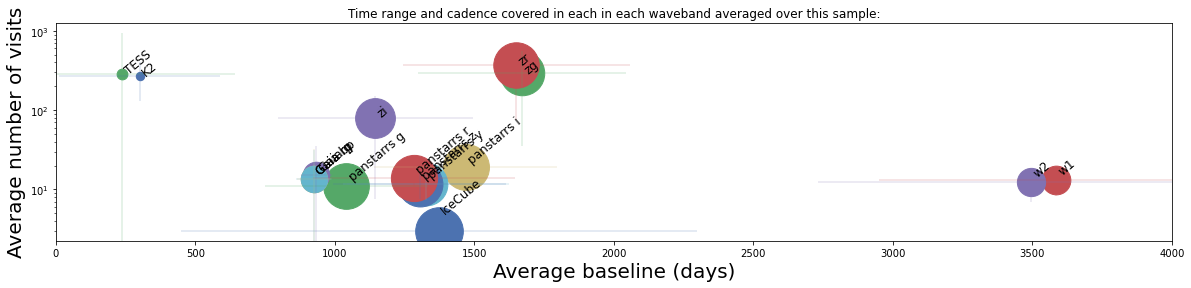

In [5]:
cadence = dict((el,[]) for el in seen.keys())
timerange = dict((el,[]) for el in seen.keys())

for b in range(numobj):
    singleobj = parallel_df_lc.data.loc[b,:,:,:]  
    label = singleobj.index.unique('label')
    bband = singleobj.index.unique('band')
    for bb in bband:
        bands = singleobj.loc[b,label[0],bb,:].index.get_level_values('time')[:]
        #bands.values
        #print(bb,len(bands[:]),np.round(bands[:].max()-bands[:].min(),1))    
        cadence[bb].append(len(bands[:]))
        if bands[:].max()-bands[:].min()>0:
            timerange[bb].append(np.round(bands[:].max()-bands[:].min(),1))    

plt.figure(figsize=(20,4))
plt.title(r'Time range and cadence covered in each in each waveband averaged over this sample:')
for el in cadence.keys():
    #print(el,len(cadence[el]),np.mean(cadence[el]),np.std(cadence[el]))
    #print(el,len(timerange[el]),np.mean(timerange[el]),np.std(timerange[el]))
    plt.scatter(np.mean(timerange[el]),np.mean(cadence[el]),label=el,s=len(timerange[el]))
    plt.errorbar(np.mean(timerange[el]),np.mean(cadence[el]),xerr=np.std(timerange[el]),yerr=np.std(cadence[el]),alpha=0.2)
    plt.annotate(el,(np.mean(timerange[el]),np.mean(cadence[el])+2),size=12, rotation=40)
plt.ylabel(r'Average number of visits',size=20) 
plt.xlabel(r'Average baseline (days)',size=20) 
plt.xlim([0,4000])
plt.yscale('log')

## Starting with ZTF alone as it has the highest average number of visits
#### unifying the grid so different objects can be compared:

  0%|          | 0/2270 [00:00<?, ?it/s]

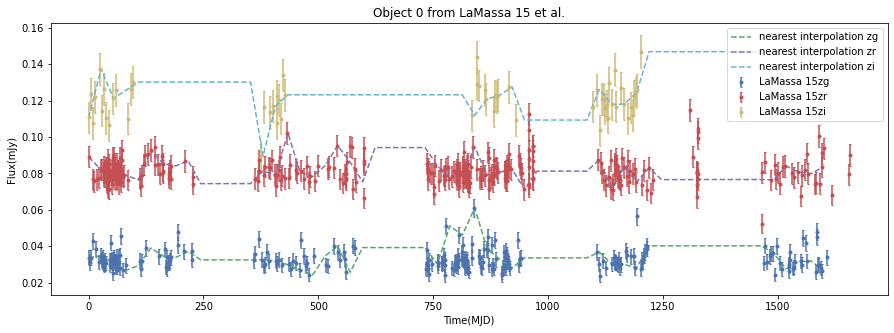

  0%|          | 1/2270 [00:00<17:32,  2.16it/s]

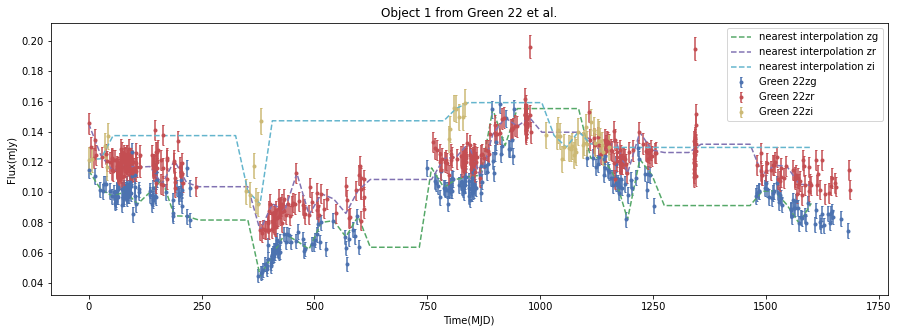

  0%|          | 2/2270 [00:00<17:01,  2.22it/s]

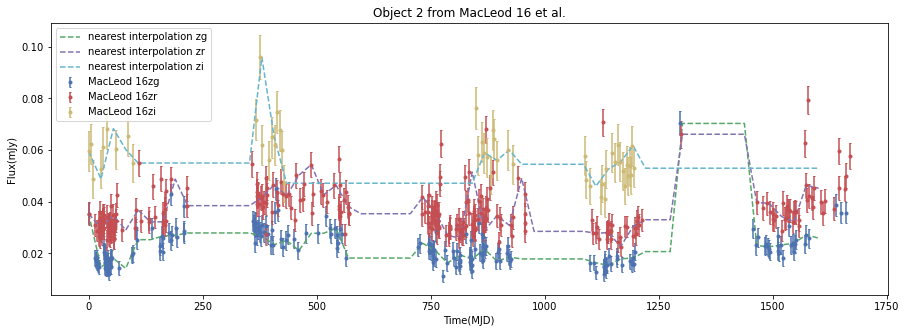

100%|██████████| 2270/2270 [01:10<00:00, 32.15it/s]


In [6]:
bands_inlc = ['zg','zr','zi']#,'panstarrs g','panstarrs r','panstarrs i','panstarrs z', 'panstarrs y']
objects,dobjects,flabels = unify_lc(parallel_df_lc,bands_inlc,xres=60,numplots=3)

# calculate some basic statistics
fvar, maxarray, meanarray = stat_bands(objects,dobjects,bands_inlc)

# combine different waveband into one array
dat = combine_bands(objects,bands_inlc)

# Normalize the combinde array by maximum of brightness in a waveband after clipping outliers:
dat = normalize_clipmax_objects(dat,maxarray,band = 1)

# shuffle data incase the ML routines are sensitive to order
data,fzr,p = shuffle_datalabel(dat,flabels)
fvar_arr,maximum_arr,average_arr = fvar[:,p],maxarray[:,p],meanarray[:,p]

# Fix label of all changing looks and TDEs 
cl_labels = ['LaMassa 15','Green 22','Hon 22','Lyu 21','Sheng 20','MacLeod 19','MacLeod 16','Ruan 16','Yang 18','Lopez-Navas 22']
for i,l in enumerate(fzr):
    if l in cl_labels:
        fzr[i] = 'CL AGN'
    if l=='ZTF-Objname':
        fzr[i] = 'TDE'

In [ ]:
plt.figure(figsize=(16,6))
markersize=200
colors = ['#e93e39','#1b2532','#6ca267','#747e8c','#14789f','#b444fc','#f9c748']


mapper = umap.UMAP(n_neighbors=50,min_dist=0.5,metric='manhattan',random_state=20).fit(data)
ax0 = plt.subplot(1,2,1)
ax0.set_title('MAnhattan Distance',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax0.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')

mapperg = umap.UMAP(n_neighbors=50,min_dist=0.5,metric=dtw_distance,random_state=20).fit(data) #this distance takes long
ax2 = plt.subplot(1,2,2)
ax2.set_title('DTW Distance',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapperg.embedding_[u,0],mapperg.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.axis('off')

In [ ]:
plt.figure(figsize=(18,6))
markersize=200
colors = ['#e93e39','#1b2532','#6ca267','#747e8c','#14789f','#b444fc','#f9c748']
mapper = umap.UMAP(n_neighbors=50,min_dist=0.5,metric='manhattan',random_state=20).fit(data)

ax1 = plt.subplot(1,3,2)
ax1.set_title(r'mean brightness',size=20)
cf = ax1.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=np.log10(np.sum(meanarray,axis=0)),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax0 = plt.subplot(1,3,3)
ax0.set_title(r'mean fractional variation',size=20)
cf = ax0.scatter(mapper.embedding_[:,0],mapper.embedding_[:,1],s=markersize,c=stretch_small_values_arctan(np.sum(fvar_arr,axis=0),factor=3),edgecolor='gray')
plt.colorbar(cf)
plt.axis('off')

ax2 = plt.subplot(1,3,1)
ax2.set_title('sample origin',size=20)
for l,lab in enumerate(np.unique(fzr)):
    u=(fzr[:]==lab)
    cf = ax2.scatter(mapper.embedding_[u,0],mapper.embedding_[u,1],s=markersize,c=colors[l],alpha=0.6,edgecolor='gray',label=lab)
plt.legend(fontsize=12)
plt.colorbar(cf)
plt.axis('off')

plt.tight_layout()
#plt.savefig('umap-Panstarrs.png')